In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
path = '/content/drive/My Drive/req_sys/hw_01/data.csv'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv(path)
# сначала избавимся от всех тех колонок, которые не нужны в 1м дз по условию  
data.drop(["oaid_hash", "banner_id0", "banner_id1", "rate0", "rate1", "g0", "g1", "coeff_sum0", "coeff_sum1"], axis=1, inplace=True)
data.head()

,date_time,zone_id,banner_id,campaign_clicks,os_id,country_id,impressions,clicks
0,2021-09-27 00:01:30.000000,0,0,0,0,0,1,1
1,2021-09-26 22:54:49.000000,1,1,0,0,1,1,1
2,2021-09-26 23:57:20.000000,2,2,3,0,0,1,1
3,2021-09-27 00:04:30.000000,3,3,0,1,1,1,1
4,2021-09-27 00:06:21.000000,4,4,0,1,0,1,1


In [4]:
def analysis(data: pd.DataFrame):
    # проверим, есть ли null значения
    count_null = data.isnull().sum().sum()
    print('Количетво null значений =', count_null)
    # посмотрим на уникальные значения для каждой фичи и для изучения распределения построим гистограмму
    features = ['os_id', 'country_id', 'banner_id', 'zone_id', 'impressions', 'campaign_clicks']
    for feature in features:
        uniq_vals = data[feature].nunique()
        print(f"Количество уникальных значений для {feature}:  {uniq_vals}")
        plt.hist(data[feature], bins=min(50,uniq_vals))
        plt.show()
   # на какие-то характеристик даты посмотрим отдельно
    data['date_time'] = pd.to_datetime(data['date_time'])
    data_time = data.copy()
    data_time['date'] = data['date_time'].dt.date
    print(data_time['date'].value_counts())


Количетво null значений = 0
Количество уникальных значений для os_id:  11


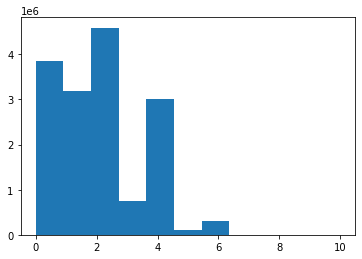

Количество уникальных значений для country_id:  17


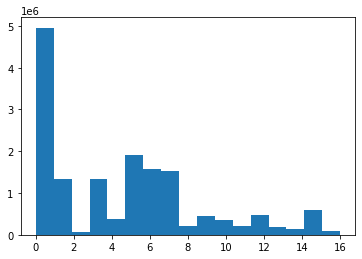

Количество уникальных значений для banner_id:  1633


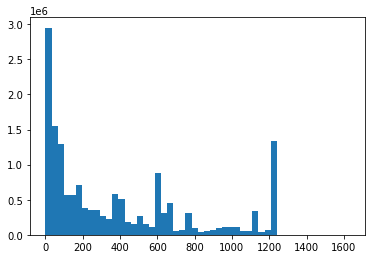

Количество уникальных значений для zone_id:  3444


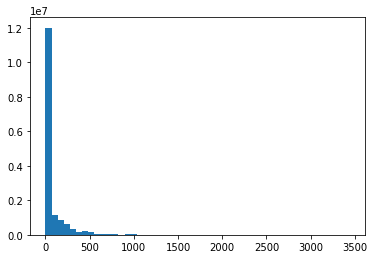

Количество уникальных значений для impressions:  1


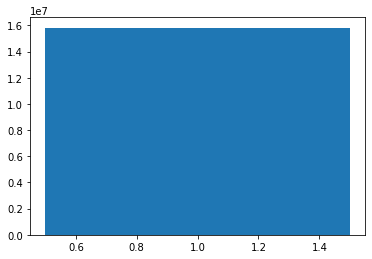

Количество уникальных значений для campaign_clicks:  822


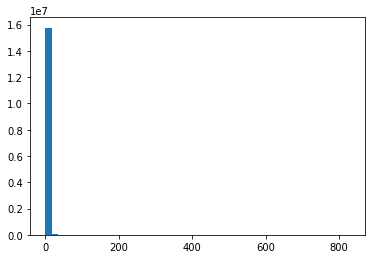

2021-09-26    3102610
2021-09-29    2420588
2021-09-27    2367303
2021-09-28    2307355
2021-10-02    2128978
2021-09-30    1851189
2021-10-01    1643448
2021-09-01          1
Name: date, dtype: int64


In [5]:
analysis(data)

Можно сделать следующие наблюдения: \\
1) null значений нет => дополнительно ничего вычищать не надо \\
2) impressions не несет никакой полезной информации, т.к. все значения в нем равны 1 => удалим \\
3) Дат не так много и видно, что все кроме одной (2021-09-01) идут последовательно друг за другом, в эту же "странную" дату попало всего 1 значение, очень похоже на выброс, поэтому уберем эту дату \\
4) campaign_clicks однозначно подлежит нормировке \\
5) Много уникальных зон и банеров, при этом плотность значений прижимается к левому краю распределения => редкие можем объединить в 1 категорию (в итоге я это не стала делать, хотя смысл определенно в этом был, но и без этого итоговый результат хороший) \\
6) Из даты больше всего информации несут часы (можно было бы еще разделить сутки на части, но я думаю, это не существенно), т.к. временные данные представлены узким временным отрезком (неделя или чуть больше) \\
7*) Я пробовала создавать интеракции (банер+час, зона + операционка), но это никак почти что не повлияло на итоговые метрики (скорее, из-за того, что веса у этих фич в итоге были небольшие и оптимизатор фичей их просто почти что все выкинул) 

In [6]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [7]:
print(data.head())

            date_time  zone_id  banner_id  campaign_clicks  os_id  country_id  \
0 2021-09-27 00:01:30        0          0                0      0           0   
1 2021-09-26 22:54:49        1          1                0      0           1   
2 2021-09-26 23:57:20        2          2                3      0           0   
3 2021-09-27 00:04:30        3          3                0      1           1   
4 2021-09-27 00:06:21        4          4                0      1           0   

   impressions  clicks  
0            1       1  
1            1       1  
2            1       1  
3            1       1  
4            1       1  


In [8]:
from scipy import sparse

In [9]:
def feature_engineering(data: pd.DataFrame) -> pd.DataFrame:
    # чистим данные в соответствии с выводами выше
    data['date_time'] = pd.to_datetime(data['date_time'])
    data = data.drop(['impressions'], axis=1)
    data = data[data['date_time'] > '2021-09-02']
    data['hour'] = data['date_time'].dt.hour
    # у нас есть категориальные фичи и условно числовая фича, которую нормируем
    numerical = ['campaign_clicks']
    # date_time сам по себе не несет какой-то информации,
    # поэтому этой колонки и нет в итоговых фичах, вместо нее - часы 
    categorial = ['os_id', 'country_id', 'banner_id', 'zone_id', 'hour']

    data[numerical] = StandardScaler().fit_transform(data[numerical])
    # делаем разбиение на трейн и тест: берем в тест последний день
    train = data[data['date_time'] < '2021-10-02']
    test = data[data['date_time'] >='2021-10-02']
    y_train = train['clicks']
    y_test = test['clicks']
    train = train.drop(['date_time', "clicks"], axis=1)
    test = test.drop(['date_time', "clicks"], axis=1)
    # делаем ван хот энкодинг категориальных фичей
    enc = OneHotEncoder(handle_unknown='ignore')
    X_train = enc.fit_transform(train[categorial])
    X_test = enc.transform(test[categorial])

    X_train = sparse.hstack([X_train, train[numerical]])
    X_test = sparse.hstack([X_test, test[numerical]])
    # конвертируем в разреженную матрицу
    X_train = X_train.tocsr()
    X_test = X_test.tocsr()
    return X_train, y_train, X_test, y_test

In [10]:
X_train, y_train, X_test, y_test = feature_engineering(data)

In [ ]:
# получилось достаточно много признаков из-за ван эн хот кодирования

In [11]:
print(X_train.shape)

(13692493, 4969)


In [12]:
from sklearn.linear_model import LogisticRegression


In [13]:
# создаем модель, берем логистическую регрессию: оптимизатор liblinear - не SGD like + обсуждалась на лекции, поэтому взяла его
# состояние фиксируем для воспроизводимости 
def create_model(C=0.1):
    model = LogisticRegression(solver='liblinear', C=C, penalty='l2', random_state=42)
    return model

In [14]:
from sklearn.model_selection import cross_validate

In [15]:
from sklearn.feature_selection import SelectFromModel

In [17]:
# слишком много фич, поэтому возьмем только те, чьи веса важны
model = create_model()
model_cut = SelectFromModel(model)
model_cut.fit(X_train, y_train)


SelectFromModel(estimator=LogisticRegression(C=0.1, random_state=42,
                                             solver='liblinear'))

In [19]:
X_train = model_cut.transform(X_train)
X_test = model_cut.transform(X_test)

In [24]:
# сделем кросс-валидацию: зададим +- стандартную сетку параметра регуляризации и переберем ее,
# перебирать виды регуляризации долго, я остановилась сразу на l2
def cv():
    C_grid = [0.001, 0.01, 0.1, 1.0, 10.0]

    for C in C_grid:
      model = create_model(C=C)
      res = cross_validate(model, X_train, y_train, scoring=['neg_log_loss', 'roc_auc'], cv=5)
      print("C= " , C)
      print('Log loss ', -np.mean(res['test_neg_log_loss']))
      print('Roc auc ', np.mean(res['test_roc_auc']))
    return res

In [25]:
res = cv()

C=  0.001
Log loss  0.11088218866473756
Roc auc  0.7044281189350821
C=  0.01
Log loss  0.11016700368551494
Roc auc  0.7150845006866104
C=  0.1
Log loss  0.11018285413721492
Roc auc  0.7166397799755533
C=  1.0
Log loss  0.11022325856755526
Roc auc  0.7169563400222765
C=  10.0
Log loss  0.11024711099902777
Roc auc  0.7169926618347953


In [31]:
best_C = 0.01

In [32]:
from sklearn.metrics import log_loss, roc_auc_score

In [35]:
# обучим модель с лучшим коэффициентом регуляризации
model = create_model(best_C)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
logloss = log_loss(y_test, model.predict_proba(X_test))
print('Auc roc = ', auc,'   logloss = ', logloss)

# сравним с бейзлайном: предикт среднего по выборке
y_pred_baseline = np.full(y_pred.shape, np.mean(y_train))
auc_baseline = roc_auc_score(y_test, y_pred_baseline)
logloss_baseline = log_loss(y_test, y_pred_baseline)
print('Auc roc = ', auc_baseline,'   logloss = ', logloss_baseline)

Auc roc =  0.7788281176914976    logloss =  0.13364395049140051
Auc roc =  0.5    logloss =  0.15486197934508547


Ура, побили бейзлайн